In [78]:
import os
from tqdm import tqdm_notebook as tqdm

# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import warnings
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import matplotlib.patches as patches
import seaborn as sns
from pylab import rcParams

%matplotlib inline 
plt.style.use('seaborn')
sns.set(style='whitegrid',color_codes=True)

# classifiaction 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
import catboost as ctb

# for classification
from sklearn.metrics import accuracy_score

# model selection
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV

# Hp optimization imports
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import mlflow

import re
import eli5
import gc
import random    
import math
import psutil
import pickle
import datetime
from time import time

# save/load models
from joblib import dump
from joblib import load

In [33]:
root = "../../data/raw/Gamma_Log_Facies_Type_Prediction/"
models_root = "../../models/Gamma_Log_Facies_Type_Prediction/"
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
pd.set_option('max_columns', 150)
# rcParams['figure.figsize'] = 16,8

In [3]:
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16 or not. feather format does not support float16.
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
%%time
train_df = pd.read_csv(root + "Train_File.csv")
test_df = pd.read_csv(root + "Test_File.csv")
submit_df = pd.read_csv(root + "Submission_File.csv")

CPU times: user 2.94 s, sys: 509 ms, total: 3.45 s
Wall time: 3.48 s


In [5]:
# reduce_mem_usage(train_df, use_float16=True);
# reduce_mem_usage(test_df, use_float16=True);

In [6]:
train_df.head()

,row_id,well_id,GR,label
0,0,0,143.510000,0
1,1,0,112.790928,0
2,2,0,123.531856,0
3,3,0,111.692784,0
4,4,0,123.613712,0


In [7]:
test_df.head()

,unique_id,row_id,well_id,GR
0,CAX_0,0,5000,113.950000
1,CAX_1,1,5000,120.896397
2,CAX_2,2,5000,115.342793
3,CAX_3,3,5000,118.859190
4,CAX_4,4,5000,127.735587


In [8]:
submit_df.head()

,unique_id,label
0,CAX_0,NaN
1,CAX_1,NaN
2,CAX_2,NaN
3,CAX_3,NaN
4,CAX_4,NaN


In [9]:
X, y = train_df.drop("label", axis=1), train_df["label"]

In [10]:
X.shape, y.shape

((4400000, 3), (4400000,))

In [11]:
extracted_features = extract_features(X, column_id="well_id", column_sort="row_id")

Feature Extraction: 100%|██████████| 20/20 [38:20<00:00, 115.04s/it] 


In [12]:
extracted_features.head()

variable,GR__abs_energy,GR__absolute_sum_of_changes,"GR__agg_autocorrelation__f_agg_""mean""__maxlag_40","GR__agg_autocorrelation__f_agg_""median""__maxlag_40","GR__agg_autocorrelation__f_agg_""var""__maxlag_40","GR__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","GR__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","GR__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","GR__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","GR__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""","GR__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""rvalue""","GR__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""slope""","GR__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""stderr""","GR__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""intercept""","GR__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""rvalue""","GR__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""slope""","GR__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""stderr""","GR__agg_linear_trend__f_agg_""mean""__chunk_len_10__attr_""intercept""","GR__agg_linear_trend__f_agg_""mean""__chunk_len_10__attr_""rvalue""","GR__agg_linear_trend__f_agg_""mean""__chunk_len_10__attr_""slope""","GR__agg_linear_trend__f_agg_""mean""__chunk_len_10__attr_""stderr""","GR__agg_linear_trend__f_agg_""mean""__chunk_len_50__attr_""intercept""","GR__agg_linear_trend__f_agg_""mean""__chunk_len_50__attr_""rvalue""","GR__agg_linear_trend__f_agg_""mean""__chunk_len_50__attr_""slope""","GR__agg_linear_trend__f_agg_""mean""__chunk_len_50__attr_""stderr""","GR__agg_linear_trend__f_agg_""mean""__chunk_len_5__attr_""intercept""","GR__agg_linear_trend__f_agg_""mean""__chunk_len_5__attr_""rvalue""","GR__agg_linear_trend__f_agg_""mean""__chunk_len_5__attr_""slope""","GR__agg_linear_trend__f_agg_""mean""__chunk_len_5__attr_""stderr""","GR__agg_linear_trend__f_agg_""min""__chunk_len_10__attr_""intercept""","GR__agg_linear_trend__f_agg_""min""__chunk_len_10__attr_""rvalue""","GR__agg_linear_trend__f_agg_""min""__chunk_len_10__attr_""slope""","GR__agg_linear_trend__f_agg_""min""__chunk_len_10__attr_""stderr""","GR__agg_linear_trend__f_agg_""min""__chunk_len_50__attr_""intercept""","GR__agg_linear_trend__f_agg_""min""__chunk_len_50__attr_""rvalue""","GR__agg_linear_trend__f_agg_""min""__chunk_len_50__attr_""slope""","GR__agg_linear_trend__f_agg_""min""__chunk_len_50__attr_""stderr""","GR__agg_linear_trend__f_agg_""min""__chunk_len_5__attr_""intercept""","GR__agg_linear_trend__f_agg_""min""__chunk_len_5__attr_""rvalue""","GR__agg_linear_trend__f_agg_""min""__chunk_len_5__attr_""slope""","GR__agg_linear_trend__f_agg_""min""__chunk_len_5__attr_""stderr""","GR__agg_linear_trend__f_agg_""var""__chunk_len_10__attr_""intercept""","GR__agg_linear_trend__f_agg_""var""__chunk_len_10__attr_""rvalue""","GR__agg_linear_trend__f_agg_""var""__chunk_len_10__attr_""slope""","GR__agg_linear_trend__f_agg_""var""__chunk_len_10__attr_""stderr""","GR__agg_linear_trend__f_agg_""var""__chunk_len_50__attr_""intercept""","GR__agg_linear_trend__f_agg_""var""__chunk_len_50__attr_""rvalue""","GR__agg_linear_trend__f_agg_""var""__chunk_len_50__attr_""slope""","GR__agg_linear_trend__f_agg_""var""__chunk_len_50__attr_""stderr""","GR__agg_linear_trend__f_agg_""var""__chunk_len_5__attr_""intercept""","GR__agg_linear_trend__f_agg_""var""__chunk_len_5__attr_""rvalue""","GR__agg_linear_trend__f_agg_""var""__chunk_len_5__attr_""slope""","GR__agg_linear_trend__f_agg_""var""__chunk_len_5__attr_""stderr""",GR__approximate_entropy__m_2__r_0.1,GR__approximate_entropy__m_2__r_0.3,GR__approximate_entropy__m_2__r_0.5,GR__approximate_entropy__m_2__r_0.7,GR__approximate_entropy__m_2__r_0.9,GR__ar_coefficient__k_10__coeff_0,GR__ar_coefficient__k_10__coeff_1,GR__ar_coefficient__k_10__coeff_2,GR__ar_coefficient__k_10__coeff_3,GR__ar_coefficient__k_10__coeff_4,"GR__augmented_dickey_fuller__attr_""pvalue""","GR__augmented_dickey_fuller__attr_""teststat""","GR__augme

In [59]:
extracted_features.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            3990, 3991, 3992, 3993, 3994, 3995, 3996, 3997, 3998, 3999],
           dtype='int64', name='id', length=4000)

In [14]:
extracted_features.to_csv(root + "Train_extracted_features.csv")

In [79]:
def clear_text(text):
    text = re.sub(r"[-()\"#/@;:<>{}+=|.?,]", "", text)
    return text

renamed_extracted_features = extracted_features.rename(clear_text, axis='columns')

In [80]:
extracted_features_for_selecting = renamed_extracted_features[renamed_extracted_features.index.isin(list(range(0,50)))]
extracted_features_for_selecting.head()

variable,GR__abs_energy,GR__absolute_sum_of_changes,GR__agg_autocorrelation__f_agg_mean__maxlag_40,GR__agg_autocorrelation__f_agg_median__maxlag_40,GR__agg_autocorrelation__f_agg_var__maxlag_40,GR__agg_linear_trend__f_agg_max__chunk_len_10__attr_intercept,GR__agg_linear_trend__f_agg_max__chunk_len_10__attr_rvalue,GR__agg_linear_trend__f_agg_max__chunk_len_10__attr_slope,GR__agg_linear_trend__f_agg_max__chunk_len_10__attr_stderr,GR__agg_linear_trend__f_agg_max__chunk_len_50__attr_intercept,GR__agg_linear_trend__f_agg_max__chunk_len_50__attr_rvalue,GR__agg_linear_trend__f_agg_max__chunk_len_50__attr_slope,GR__agg_linear_trend__f_agg_max__chunk_len_50__attr_stderr,GR__agg_linear_trend__f_agg_max__chunk_len_5__attr_intercept,GR__agg_linear_trend__f_agg_max__chunk_len_5__attr_rvalue,GR__agg_linear_trend__f_agg_max__chunk_len_5__attr_slope,GR__agg_linear_trend__f_agg_max__chunk_len_5__attr_stderr,GR__agg_linear_trend__f_agg_mean__chunk_len_10__attr_intercept,GR__agg_linear_trend__f_agg_mean__chunk_len_10__attr_rvalue,GR__agg_linear_trend__f_agg_mean__chunk_len_10__attr_slope,GR__agg_linear_trend__f_agg_mean__chunk_len_10__attr_stderr,GR__agg_linear_trend__f_agg_mean__chunk_len_50__attr_intercept,GR__agg_linear_trend__f_agg_mean__chunk_len_50__attr_rvalue,GR__agg_linear_trend__f_agg_mean__chunk_len_50__attr_slope,GR__agg_linear_trend__f_agg_mean__chunk_len_50__attr_stderr,GR__agg_linear_trend__f_agg_mean__chunk_len_5__attr_intercept,GR__agg_linear_trend__f_agg_mean__chunk_len_5__attr_rvalue,GR__agg_linear_trend__f_agg_mean__chunk_len_5__attr_slope,GR__agg_linear_trend__f_agg_mean__chunk_len_5__attr_stderr,GR__agg_linear_trend__f_agg_min__chunk_len_10__attr_intercept,GR__agg_linear_trend__f_agg_min__chunk_len_10__attr_rvalue,GR__agg_linear_trend__f_agg_min__chunk_len_10__attr_slope,GR__agg_linear_trend__f_agg_min__chunk_len_10__attr_stderr,GR__agg_linear_trend__f_agg_min__chunk_len_50__attr_intercept,GR__agg_linear_trend__f_agg_min__chunk_len_50__attr_rvalue,GR__agg_linear_trend__f_agg_min__chunk_len_50__attr_slope,GR__agg_linear_trend__f_agg_min__chunk_len_50__attr_stderr,GR__agg_linear_trend__f_agg_min__chunk_len_5__attr_intercept,GR__agg_linear_trend__f_agg_min__chunk_len_5__attr_rvalue,GR__agg_linear_trend__f_agg_min__chunk_len_5__attr_slope,GR__agg_linear_trend__f_agg_min__chunk_len_5__attr_stderr,GR__agg_linear_trend__f_agg_var__chunk_len_10__attr_intercept,GR__agg_linear_trend__f_agg_var__chunk_len_10__attr_rvalue,GR__agg_linear_trend__f_agg_var__chunk_len_10__attr_slope,GR__agg_linear_trend__f_agg_var__chunk_len_10__attr_stderr,GR__agg_linear_trend__f_agg_var__chunk_len_50__attr_intercept,GR__agg_linear_trend__f_agg_var__chunk_len_50__attr_rvalue,GR__agg_linear_trend__f_agg_var__chunk_len_50__attr_slope,GR__agg_linear_trend__f_agg_var__chunk_len_50__attr_stderr,GR__agg_linear_trend__f_agg_var__chunk_len_5__attr_intercept,GR__agg_linear_trend__f_agg_var__chunk_len_5__attr_rvalue,GR__agg_linear_trend__f_agg_var__chunk_len_5__attr_slope,GR__agg_linear_trend__f_agg_var__chunk_len_5__attr_stderr,GR__approximate_entropy__m_2__r_01,GR__approximate_entropy__m_2__r_03,GR__approximate_entropy__m_2__r_05,GR__approximate_entropy__m_2__r_07,GR__approximate_entropy__m_2__r_09,GR__ar_coefficient__k_10__coeff_0,GR__ar_coefficient__k_10__coeff_1,GR__ar_coefficient__k_10__coeff_2,GR__ar_coefficient__k_10__coeff_3,GR__ar_coefficient__k_10__coeff_4,GR__augmented_dickey_fuller__attr_pvalue,GR__augmented_dickey_fuller__attr_teststat,GR__augmented_dickey_fuller__attr_usedlag,GR__autocorrelation__lag_0,GR__autocorrelation__lag_1,GR__autocorrelation__lag_2,GR__autocorrelation__lag_3,GR__autocorrelation__lag_4,GR__autocorrelation__lag_5,GR__autocorrelation__lag_6,GR__autocorrelation__lag_7,GR__autocorrelation__lag_8,...,GR__number_peaks__n_10,GR__number_peaks__n_3,GR__number_peaks__n_5,GR__number_peaks__n_50,GR__partial_autocorrelation__lag_0,GR__partial_autocorrelation__lag_1,GR__partial_autocorrelation__lag_2,GR__partial_autocorrelation__lag_3,GR__pa

In [24]:
train_df_for_features_selecting = train_df[train_df["well_id"] < 50]

In [25]:
train_df_for_features_selecting.head()

,row_id,well_id,GR,label
_temporary_index_column,,,,
0,0,0,143.510000,0
1,1,0,112.790928,0
2,2,0,123.531856,0
3,3,0,111.692784,0
4,4,0,123.613712,0


In [26]:
train_df_for_features_selecting.shape

(55000, 4)

In [81]:
train_df_features = train_df_for_features_selecting.merge(extracted_features_for_selecting, left_on='well_id', right_on='id')

In [82]:
train_df_features.shape

(55000, 758)

In [83]:
train_df_features.head()

,row_id,well_id,GR,label,GR__abs_energy,GR__absolute_sum_of_changes,GR__agg_autocorrelation__f_agg_mean__maxlag_40,GR__agg_autocorrelation__f_agg_median__maxlag_40,GR__agg_autocorrelation__f_agg_var__maxlag_40,GR__agg_linear_trend__f_agg_max__chunk_len_10__attr_intercept,GR__agg_linear_trend__f_agg_max__chunk_len_10__attr_rvalue,GR__agg_linear_trend__f_agg_max__chunk_len_10__attr_slope,GR__agg_linear_trend__f_agg_max__chunk_len_10__attr_stderr,GR__agg_linear_trend__f_agg_max__chunk_len_50__attr_intercept,GR__agg_linear_trend__f_agg_max__chunk_len_50__attr_rvalue,GR__agg_linear_trend__f_agg_max__chunk_len_50__attr_slope,GR__agg_linear_trend__f_agg_max__chunk_len_50__attr_stderr,GR__agg_linear_trend__f_agg_max__chunk_len_5__attr_intercept,GR__agg_linear_trend__f_agg_max__chunk_len_5__attr_rvalue,GR__agg_linear_trend__f_agg_max__chunk_len_5__attr_slope,GR__agg_linear_trend__f_agg_max__chunk_len_5__attr_stderr,GR__agg_linear_trend__f_agg_mean__chunk_len_10__attr_intercept,GR__agg_linear_trend__f_agg_mean__chunk_len_10__attr_rvalue,GR__agg_linear_trend__f_agg_mean__chunk_len_10__attr_slope,GR__agg_linear_trend__f_agg_mean__chunk_len_10__attr_stderr,GR__agg_linear_trend__f_agg_mean__chunk_len_50__attr_intercept,GR__agg_linear_trend__f_agg_mean__chunk_len_50__attr_rvalue,GR__agg_linear_trend__f_agg_mean__chunk_len_50__attr_slope,GR__agg_linear_trend__f_agg_mean__chunk_len_50__attr_stderr,GR__agg_linear_trend__f_agg_mean__chunk_len_5__attr_intercept,GR__agg_linear_trend__f_agg_mean__chunk_len_5__attr_rvalue,GR__agg_linear_trend__f_agg_mean__chunk_len_5__attr_slope,GR__agg_linear_trend__f_agg_mean__chunk_len_5__attr_stderr,GR__agg_linear_trend__f_agg_min__chunk_len_10__attr_intercept,GR__agg_linear_trend__f_agg_min__chunk_len_10__attr_rvalue,GR__agg_linear_trend__f_agg_min__chunk_len_10__attr_slope,GR__agg_linear_trend__f_agg_min__chunk_len_10__attr_stderr,GR__agg_linear_trend__f_agg_min__chunk_len_50__attr_intercept,GR__agg_linear_trend__f_agg_min__chunk_len_50__attr_rvalue,GR__agg_linear_trend__f_agg_min__chunk_len_50__attr_slope,GR__agg_linear_trend__f_agg_min__chunk_len_50__attr_stderr,GR__agg_linear_trend__f_agg_min__chunk_len_5__attr_intercept,GR__agg_linear_trend__f_agg_min__chunk_len_5__attr_rvalue,GR__agg_linear_trend__f_agg_min__chunk_len_5__attr_slope,GR__agg_linear_trend__f_agg_min__chunk_len_5__attr_stderr,GR__agg_linear_trend__f_agg_var__chunk_len_10__attr_intercept,GR__agg_linear_trend__f_agg_var__chunk_len_10__attr_rvalue,GR__agg_linear_trend__f_agg_var__chunk_len_10__attr_slope,GR__agg_linear_trend__f_agg_var__chunk_len_10__attr_stderr,GR__agg_linear_trend__f_agg_var__chunk_len_50__attr_intercept,GR__agg_linear_trend__f_agg_var__chunk_len_50__attr_rvalue,GR__agg_linear_trend__f_agg_var__chunk_len_50__attr_slope,GR__agg_linear_trend__f_agg_var__chunk_len_50__attr_stderr,GR__agg_linear_trend__f_agg_var__chunk_len_5__attr_intercept,GR__agg_linear_trend__f_agg_var__chunk_len_5__attr_rvalue,GR__agg_linear_trend__f_agg_var__chunk_len_5__attr_slope,GR__agg_linear_trend__f_agg_var__chunk_len_5__attr_stderr,GR__approximate_entropy__m_2__r_01,GR__approximate_entropy__m_2__r_03,GR__approximate_entropy__m_2__r_05,GR__approximate_entropy__m_2__r_07,GR__approximate_entropy__m_2__r_09,GR__ar_coefficient__k_10__coeff_0,GR__ar_coefficient__k_10__coeff_1,GR__ar_coefficient__k_10__coeff_2,GR__ar_coefficient__k_10__coeff_3,GR__ar_coefficient__k_10__coeff_4,GR__augmented_dickey_fuller__attr_pvalue,GR__augmented_dickey_fuller__attr_teststat,GR__augmented_dickey_fuller__attr_usedlag,GR__autocorrelation__lag_0,GR__autocorrelation__lag_1,GR__autocorrelation__lag_2,GR__autocorrelation__lag_3,GR__autocorrelation__lag_4,...,GR__number_peaks__n_10,GR__number_peaks__n_3,GR__number_peaks__n_5,GR__number_peaks__n_50,GR__partial_autocorrelation__lag_0,GR__partial_autocorrelation__lag_1,GR__partial_autocorrelation__lag_2,GR__partial_autocorrelation__lag_3,GR__partial_autocorrelation__lag_4,GR__partial_autocorrelation__lag_5,GR__partial_autocorrelation_

In [84]:
valid_df_for_features_selecting = train_df[train_df["well_id"].isin(list(range(50,70)))]
valid_features_selecting = renamed_extracted_features[renamed_extracted_features.index.isin(list(range(50,70)))]

In [85]:
valid_df_for_features_selecting.head()

,row_id,well_id,GR,label
_temporary_index_column,,,,
55000,0,50,107.340000,0
55001,1,50,108.142757,0
55002,2,50,121.515514,0
55003,3,50,120.608271,0
55004,4,50,129.161028,0


In [86]:
valid_df_for_features_selecting.shape

(22000, 4)

In [87]:
valid_df_features = valid_df_for_features_selecting.merge(valid_features_selecting, left_on='well_id', right_on='id')

In [88]:
valid_df_features.head()

,row_id,well_id,GR,label,GR__abs_energy,GR__absolute_sum_of_changes,GR__agg_autocorrelation__f_agg_mean__maxlag_40,GR__agg_autocorrelation__f_agg_median__maxlag_40,GR__agg_autocorrelation__f_agg_var__maxlag_40,GR__agg_linear_trend__f_agg_max__chunk_len_10__attr_intercept,GR__agg_linear_trend__f_agg_max__chunk_len_10__attr_rvalue,GR__agg_linear_trend__f_agg_max__chunk_len_10__attr_slope,GR__agg_linear_trend__f_agg_max__chunk_len_10__attr_stderr,GR__agg_linear_trend__f_agg_max__chunk_len_50__attr_intercept,GR__agg_linear_trend__f_agg_max__chunk_len_50__attr_rvalue,GR__agg_linear_trend__f_agg_max__chunk_len_50__attr_slope,GR__agg_linear_trend__f_agg_max__chunk_len_50__attr_stderr,GR__agg_linear_trend__f_agg_max__chunk_len_5__attr_intercept,GR__agg_linear_trend__f_agg_max__chunk_len_5__attr_rvalue,GR__agg_linear_trend__f_agg_max__chunk_len_5__attr_slope,GR__agg_linear_trend__f_agg_max__chunk_len_5__attr_stderr,GR__agg_linear_trend__f_agg_mean__chunk_len_10__attr_intercept,GR__agg_linear_trend__f_agg_mean__chunk_len_10__attr_rvalue,GR__agg_linear_trend__f_agg_mean__chunk_len_10__attr_slope,GR__agg_linear_trend__f_agg_mean__chunk_len_10__attr_stderr,GR__agg_linear_trend__f_agg_mean__chunk_len_50__attr_intercept,GR__agg_linear_trend__f_agg_mean__chunk_len_50__attr_rvalue,GR__agg_linear_trend__f_agg_mean__chunk_len_50__attr_slope,GR__agg_linear_trend__f_agg_mean__chunk_len_50__attr_stderr,GR__agg_linear_trend__f_agg_mean__chunk_len_5__attr_intercept,GR__agg_linear_trend__f_agg_mean__chunk_len_5__attr_rvalue,GR__agg_linear_trend__f_agg_mean__chunk_len_5__attr_slope,GR__agg_linear_trend__f_agg_mean__chunk_len_5__attr_stderr,GR__agg_linear_trend__f_agg_min__chunk_len_10__attr_intercept,GR__agg_linear_trend__f_agg_min__chunk_len_10__attr_rvalue,GR__agg_linear_trend__f_agg_min__chunk_len_10__attr_slope,GR__agg_linear_trend__f_agg_min__chunk_len_10__attr_stderr,GR__agg_linear_trend__f_agg_min__chunk_len_50__attr_intercept,GR__agg_linear_trend__f_agg_min__chunk_len_50__attr_rvalue,GR__agg_linear_trend__f_agg_min__chunk_len_50__attr_slope,GR__agg_linear_trend__f_agg_min__chunk_len_50__attr_stderr,GR__agg_linear_trend__f_agg_min__chunk_len_5__attr_intercept,GR__agg_linear_trend__f_agg_min__chunk_len_5__attr_rvalue,GR__agg_linear_trend__f_agg_min__chunk_len_5__attr_slope,GR__agg_linear_trend__f_agg_min__chunk_len_5__attr_stderr,GR__agg_linear_trend__f_agg_var__chunk_len_10__attr_intercept,GR__agg_linear_trend__f_agg_var__chunk_len_10__attr_rvalue,GR__agg_linear_trend__f_agg_var__chunk_len_10__attr_slope,GR__agg_linear_trend__f_agg_var__chunk_len_10__attr_stderr,GR__agg_linear_trend__f_agg_var__chunk_len_50__attr_intercept,GR__agg_linear_trend__f_agg_var__chunk_len_50__attr_rvalue,GR__agg_linear_trend__f_agg_var__chunk_len_50__attr_slope,GR__agg_linear_trend__f_agg_var__chunk_len_50__attr_stderr,GR__agg_linear_trend__f_agg_var__chunk_len_5__attr_intercept,GR__agg_linear_trend__f_agg_var__chunk_len_5__attr_rvalue,GR__agg_linear_trend__f_agg_var__chunk_len_5__attr_slope,GR__agg_linear_trend__f_agg_var__chunk_len_5__attr_stderr,GR__approximate_entropy__m_2__r_01,GR__approximate_entropy__m_2__r_03,GR__approximate_entropy__m_2__r_05,GR__approximate_entropy__m_2__r_07,GR__approximate_entropy__m_2__r_09,GR__ar_coefficient__k_10__coeff_0,GR__ar_coefficient__k_10__coeff_1,GR__ar_coefficient__k_10__coeff_2,GR__ar_coefficient__k_10__coeff_3,GR__ar_coefficient__k_10__coeff_4,GR__augmented_dickey_fuller__attr_pvalue,GR__augmented_dickey_fuller__attr_teststat,GR__augmented_dickey_fuller__attr_usedlag,GR__autocorrelation__lag_0,GR__autocorrelation__lag_1,GR__autocorrelation__lag_2,GR__autocorrelation__lag_3,GR__autocorrelation__lag_4,...,GR__number_peaks__n_10,GR__number_peaks__n_3,GR__number_peaks__n_5,GR__number_peaks__n_50,GR__partial_autocorrelation__lag_0,GR__partial_autocorrelation__lag_1,GR__partial_autocorrelation__lag_2,GR__partial_autocorrelation__lag_3,GR__partial_autocorrelation__lag_4,GR__partial_autocorrelation__lag_5,GR__partial_autocorrelation_

In [89]:
valid_df_features.shape

(22000, 758)

In [111]:
X_train, y_train, X_test, y_test = train_df_features.drop(["label", "GR__number_crossing_m__m_1", "GR__value_count__value_1"], axis=1), train_df_features["label"], \
            valid_df_features.drop(["label", "GR__number_crossing_m__m_1", "GR__value_count__value_1"], axis=1), valid_df_features["label"]

In [91]:
X_train.columns.values

array(['row_id', 'well_id', 'GR', 'GR__abs_energy',
       'GR__absolute_sum_of_changes',
       'GR__agg_autocorrelation__f_agg_mean__maxlag_40',
       'GR__agg_autocorrelation__f_agg_median__maxlag_40',
       'GR__agg_autocorrelation__f_agg_var__maxlag_40',
       'GR__agg_linear_trend__f_agg_max__chunk_len_10__attr_intercept',
       'GR__agg_linear_trend__f_agg_max__chunk_len_10__attr_rvalue',
       'GR__agg_linear_trend__f_agg_max__chunk_len_10__attr_slope',
       'GR__agg_linear_trend__f_agg_max__chunk_len_10__attr_stderr',
       'GR__agg_linear_trend__f_agg_max__chunk_len_50__attr_intercept',
       'GR__agg_linear_trend__f_agg_max__chunk_len_50__attr_rvalue',
       'GR__agg_linear_trend__f_agg_max__chunk_len_50__attr_slope',
       'GR__agg_linear_trend__f_agg_max__chunk_len_50__attr_stderr',
       'GR__agg_linear_trend__f_agg_max__chunk_len_5__attr_intercept',
       'GR__agg_linear_trend__f_agg_max__chunk_len_5__attr_rvalue',
       'GR__agg_linear_trend__f_agg_max__ch

In [110]:
import collections
[item for item, count in collections.Counter(X_train.columns.values).items() if count > 1]

['GR__value_count__value_1']

In [97]:
X_train.shape

(55000, 755)

In [104]:
len(X_train.columns.values)

755

In [108]:
temp3 = [x for x in X_train.columns.values if x not in np.unique(X_train.columns.values)]

In [109]:
temp3

[]

In [112]:
mlflow.set_experiment("xgboost_cls_feature_selecting")

class HyperoptHPOptimizer:
    
    def __init__(self, hyperparameters_space, max_evals):
        self.trials = Trials()
        self.max_evals = max_evals
        self.hyperparameters_space = hyperparameters_space
        self.skf = StratifiedKFold(n_splits=3, shuffle=False, random_state=RANDOM_STATE)
    
    def get_loss(self, hyperparameters):
        # MLflow will track and save hyperparameters, loss, and scores. 
        with mlflow.start_run(run_name='hyperopt_param'):
            params = {
                'min_child_weight': 8,
                'gamma': 3,
                'subsample': 1,
                'colsample_bytree': 0.6,
                'eta': 0.3,
                'max_depth':  4,
                'random_state': RANDOM_STATE, 
                'verbosity': 1, 
                'n_jobs': -1, 
                'n_estimators': 10, 
                'learning_rate': 0.1, 
            }
            cols = [col for col, is_use in hyperparameters.items() if is_use == 1]
            for k, v in hyperparameters.items():
                mlflow.log_param(k, v)
            model = xgb.XGBClassifier(**params)
            model.fit(X_train[cols], y_train)
            y_pred = model.predict(X_test[cols])
            loss = accuracy_score(y_test, y_pred)
            # Log the various losses and metrics (on train and validation)
            mlflow.log_metric("accuracy", loss)
            # Use the last validation loss from the history object to optimize
            return {
                'loss': -loss, 
                'status': STATUS_OK,
                'eval_time': time()
            }

    def optimize(self):
        """
        This is the optimization function that given a space of 
        hyperparameters and a scoring function, finds the best hyperparameters.
        """
        # Use the fmin function from Hyperopt to find the best hyperparameters
        # Here we use the tree-parzen estimator method. 
        best = fmin(self.get_loss, self.hyperparameters_space, algo=tpe.suggest, 
                    trials=self.trials,  max_evals=self.max_evals)
        return best



MAX_EVALS = 200

HYPERPARAMETERS_SPACE = {col: hp.choice(col, [0, 1]) for col in X_train.columns.values}

hp_optimizer = HyperoptHPOptimizer(hyperparameters_space=HYPERPARAMETERS_SPACE, max_evals=MAX_EVALS)
optimal_hyperparameters = hp_optimizer.optimize()
print(optimal_hyperparameters)

 64%|██████▎   | 127/200 [2:38:40<1:31:12, 74.96s/it, best loss: -0.6591363636363636]


KeyboardInterrupt: 

In [113]:
optimal_hyperparameters

NameError: name 'optimal_hyperparameters' is not defined

In [ ]:
X_merge = X.merge(extracted_features, left_on='well_id', right_on='id')

Process ForkPoolWorker-11:
Process ForkPoolWorker-12:
Process ForkPoolWorker-10:
Process ForkPoolWorker-9:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.4_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.7.4_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.7.4_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.7.4_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/Cellar/python/3.7.4_1/Frameworks/Python.framework/Versi

In [ ]:
X_merge.head()

In [ ]:
X_merge.shape

In [30]:
impute(extracted_features)
features_filtered = select_features(extracted_features, y)

AssertionError: X and y must contain the same number of samples.

In [ ]:
features_filtered_direct = extract_relevant_features(X, y, column_id='well_id', column_sort='row_id')

In [ ]:
features_filtered_direct.head()

In [ ]:
mlflow.set_experiment("gamma_log_facies_type_xgboost_cls_hyperopt_subset")

class HyperoptHPOptimizer:
    
    def __init__(self, hyperparameters_space, max_evals):
        self.trials = Trials()
        self.max_evals = max_evals
        self.hyperparameters_space = hyperparameters_space
        self.skf = StratifiedKFold(n_splits=3, shuffle=False, random_state=RANDOM_STATE)
    
    def get_loss(self, hyperparameters):
        # MLflow will track and save hyperparameters, loss, and scores. 
        with mlflow.start_run(run_name='hyperopt_param'):
            print("Training with the following hyperparameters: ")
            print(hyperparameters)
            for k, v in hyperparameters.items():
                mlflow.log_param(k, v)
            model = xgb.XGBClassifier(**hyperparameters)
            X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=RANDOM_STATE, stratify=y_subset)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            loss = accuracy_score(y_test, y_pred)
            # Log the various losses and metrics (on train and validation)
            mlflow.log_metric("accuracy", loss)
            # Use the last validation loss from the history object to optimize
            return {
                'loss': -loss, 
                'status': STATUS_OK,
                'eval_time': time()
            }

    def optimize(self):
        """
        This is the optimization function that given a space of 
        hyperparameters and a scoring function, finds the best hyperparameters.
        """
        # Use the fmin function from Hyperopt to find the best hyperparameters
        # Here we use the tree-parzen estimator method. 
        best = fmin(self.get_loss, self.hyperparameters_space, algo=tpe.suggest, 
                    trials=self.trials,  max_evals=self.max_evals)
        return best



MAX_EVALS = 150

HYPERPARAMETERS_SPACE = {
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 10, dtype=int)),
    'gamma': hp.choice('gamma', np.arange(0.5, 5)),
    'subsample': hp.choice('subsample', [0.6, 0.8, 1.0]),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.6, 1.0)),
    'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
    'max_depth':  hp.choice('max_depth', np.arange(4, 14, dtype=int)),
    'random_state': RANDOM_STATE, 
    'verbosity': 1, 
    'n_jobs': -1, 
    'n_estimators': 20, 
    'learning_rate': 0.02, 
}

hp_optimizer = HyperoptHPOptimizer(hyperparameters_space=HYPERPARAMETERS_SPACE, max_evals=MAX_EVALS)
optimal_hyperparameters = hp_optimizer.optimize()
print(optimal_hyperparameters)

In [141]:
train_df_ts = train_df[train_df["well_id"] < 50]

In [142]:
train_df_ts.head(10)

,row_id,well_id,GR,label
_temporary_index_column,,,,
0,0,0,143.510000,0
1,1,0,112.790928,0
2,2,0,123.531856,0
3,3,0,111.692784,0
4,4,0,123.613712,0
5,5,0,120.414641,0
6,6,0,123.145569,0
7,7,0,114.216497,0
8,8,0,119.387425,0


In [145]:
def create_lags(df):
    for i in range(0, 25):
        df["lag_forward_{}".format(i)] = df.GR.shift(i)
        df["lag_backward_{}".format(i)] = df.GR.shift(-i)
    return df

train_df_ts = train_df_ts.groupby("well_id").apply(create_lags)
train_df_ts = train_df_ts.fillna(0)
    

In [146]:
train_df_ts.shape

(55000, 54)

In [149]:
valid_df_ts = train_df[train_df["well_id"].isin(list(range(50,70)))]
valid_df_ts = valid_df_ts.groupby("well_id").apply(create_lags)
valid_df_ts = valid_df_ts.fillna(0)

In [150]:
X_train, y_train, X_test, y_test = train_df_ts.drop(["label"], axis=1), train_df_ts["label"], \
            valid_df_ts.drop(["label"], axis=1), valid_df_ts["label"]

In [161]:
mlflow.set_experiment("gamma_log_facies_type_RandomForestClassifier_lag_dataset")

class HyperoptHPOptimizer:
    
    def __init__(self, hyperparameters_space, max_evals):
        self.trials = Trials()
        self.max_evals = max_evals
        self.hyperparameters_space = hyperparameters_space
        self.skf = StratifiedKFold(n_splits=3, shuffle=False, random_state=RANDOM_STATE)
    
    def get_loss(self, hyperparameters):
        # MLflow will track and save hyperparameters, loss, and scores. 
        with mlflow.start_run(run_name='hyperopt_param'):
            print("Training with the following hyperparameters: ")
            print(hyperparameters)
            for k, v in hyperparameters.items():
                mlflow.log_param(k, v)
            model = RandomForestClassifier(**hyperparameters)   
        
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            loss = accuracy_score(y_test, y_pred)
            
            # Log the various losses and metrics (on train and validation)
            mlflow.log_metric("accuracy", loss)
            # Use the last validation loss from the history object to optimize
            return {'loss': -loss, 'status': STATUS_OK}

    def optimize(self):
        """
        This is the optimization function that given a space of 
        hyperparameters and a scoring function, finds the best hyperparameters.
        """
        # Use the fmin function from Hyperopt to find the best hyperparameters
        # Here we use the tree-parzen estimator method. 
        best = fmin(self.get_loss, self.hyperparameters_space, algo=tpe.suggest, 
                    trials=self.trials,  max_evals=self.max_evals)
        return best
    
MAX_EVALS = 100

HYPERPARAMETERS_SPACE = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', range(5,54)),
    'min_samples_split': hp.choice('min_samples_split', range(10,40)),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(5,30)),
    'n_estimators': 100,
    'criterion': hp.choice('criterion', ["gini", "entropy"]),
    'n_jobs': -1,
    'random_state': RANDOM_STATE,
    'class_weight': hp.choice('class_weight', [None, 'balanced', 'balanced_subsample'])
}

hp_optimizer = HyperoptHPOptimizer(hyperparameters_space=HYPERPARAMETERS_SPACE, max_evals=MAX_EVALS)
optimal_hyperparameters = hp_optimizer.optimize()
print(optimal_hyperparameters)

Training with the following hyperparameters:         
{'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': 35, 'min_samples_leaf': 18, 'min_samples_split': 15, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
Training with the following hyperparameters:                                   
{'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 14, 'max_features': 5, 'min_samples_leaf': 11, 'min_samples_split': 15, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
Training with the following hyperparameters:                                   
{'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 14, 'max_features': 23, 'min_samples_leaf': 7, 'min_samples_split': 27, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
Training with the following hyperparameters:                                   
{'class_weight': None, 'criterion': 'entropy', 'max_depth': 13, 'max_features': 53, 'min_samples_leaf': 11, 'min_sample

In [ ]:
[{0:1}, {1:5}, {2:5}, {3:5}, {4:5}]

In [180]:
train = train_df
train = train.groupby("well_id").apply(create_lags)
train = train.fillna(0)
X_train, y_train = train.drop("label", axis=1), train["label"]

test = test_df[["row_id", "well_id", "GR"]]
test = test.groupby("well_id").apply(create_lags)
X_test = test.fillna(0)

In [188]:
hyperparameters = {
    'class_weight': 'balanced_subsample',
    'max_features': 34,
    'max_depth':  15,
    'min_samples_leaf': 2, 
    'min_samples_split': 3,
    'random_state': RANDOM_STATE, 
    'n_estimators': 100,
    'criterion': "entropy",
    'n_jobs': -1,
}

In [189]:
X_train.shape, y_train.shape, X_test.shape

((4400000, 53), (4400000,), (2200000, 53))

In [190]:
%%time

model = RandomForestClassifier(**hyperparameters)  
model.fit(X_train, y_train)

CPU times: user 17h 4min 37s, sys: 4min 20s, total: 17h 8min 57s
Wall time: 2h 31min 53s


RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
                       criterion='entropy', max_depth=15, max_features=34,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=3, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [191]:
%%time

y_hat = model.predict(X_test)

CPU times: user 1min 24s, sys: 6.82 s, total: 1min 31s
Wall time: 19.3 s


In [192]:
submit_df["label"] = y_hat
submit_df.to_csv(root+"submission.csv", index=False)
submit_df.head(20)

,unique_id,label
0,CAX_0,0
1,CAX_1,0
2,CAX_2,0
3,CAX_3,0
4,CAX_4,0
5,CAX_5,0
6,CAX_6,0
7,CAX_7,0
8,CAX_8,4
9,CAX_9,0


<BarContainer object of 5 artists>

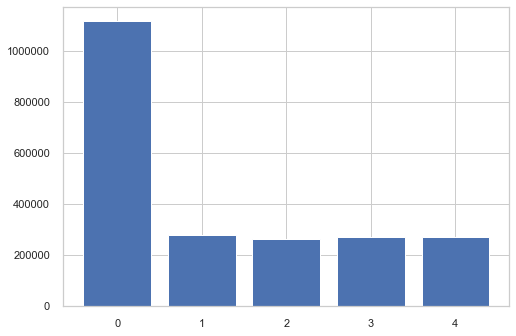

In [193]:
# Количество классов для предсказания
g = submit_df["label"].value_counts()
g = g.sort_index().T
plt.bar(g.index, g.values)

In [195]:
model_file = models_root + "gamma_log_facies_type_RandomForestClassifier_lag_dataset_100_trees_1.pkl"
dump(model, model_file)
# loaded_model = load(model_file)

['../../models/Gamma_Log_Facies_Type_Prediction/gamma_log_facies_type_RandomForestClassifier_lag_dataset_100_trees_1.pkl']

In [196]:
%%time
train_df = pd.read_csv(root + "Train_File.csv")
test_df = pd.read_csv(root + "Test_File.csv")
submit_df = pd.read_csv(root + "Submission_File.csv")

CPU times: user 3.04 s, sys: 763 ms, total: 3.81 s
Wall time: 4.37 s


In [197]:
def create_lags(df):
    for i in range(0, 25):
        df["lag_forward_{}".format(i)] = df.GR.shift(i)
        df["lag_backward_{}".format(i)] = df.GR.shift(-i)
    return df

In [198]:
train_df_ts = train_df[train_df["well_id"] < 50]
train_df_ts = train_df_ts.groupby("well_id").apply(create_lags)
train_df_ts = train_df_ts.fillna(0)

In [199]:
valid_df_ts = train_df[train_df["well_id"].isin(list(range(50,70)))]
valid_df_ts = valid_df_ts.groupby("well_id").apply(create_lags)
valid_df_ts = valid_df_ts.fillna(0)

In [200]:
X_train, y_train, X_test, y_test = train_df_ts.drop(["label"], axis=1), train_df_ts["label"], \
            valid_df_ts.drop(["label"], axis=1), valid_df_ts["label"]

In [201]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((55000, 53), (55000,), (22000, 53), (22000,))

In [205]:
weight_ratio = float(len(y_train[y_train == 0]))/float(len(y_train[y_train == 1]))
w_array = np.array([1]*y_train.shape[0])
w_array[y_train==1] = weight_ratio
w_array[y_train==0] = 1-weight_ratio

In [206]:
w_array

array([-3, -3, -3, ..., -3, -3, -3])

In [208]:
mlflow.set_experiment("xgboost_cls_hyperopt_lag_dataset")

class HyperoptHPOptimizer:
    
    def __init__(self, hyperparameters_space, max_evals):
        self.trials = Trials()
        self.max_evals = max_evals
        self.hyperparameters_space = hyperparameters_space
        self.skf = StratifiedKFold(n_splits=3, shuffle=False, random_state=RANDOM_STATE)
    
    def get_loss(self, hyperparameters):
        # MLflow will track and save hyperparameters, loss, and scores. 
        with mlflow.start_run(run_name='hyperopt_param'):
            print("Training with the following hyperparameters: ")
            print(hyperparameters)
            for k, v in hyperparameters.items():
                mlflow.log_param(k, v)
            model = xgb.XGBClassifier(**hyperparameters)
            
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
           
            loss = accuracy_score(y_test, y_pred)
            # Log the various losses and metrics (on train and validation)
            mlflow.log_metric("accuracy", loss)
            # Use the last validation loss from the history object to optimize
            return {
                'loss': -loss, 
                'status': STATUS_OK,
                'eval_time': time()
            }

    def optimize(self):
        """
        This is the optimization function that given a space of 
        hyperparameters and a scoring function, finds the best hyperparameters.
        """
        # Use the fmin function from Hyperopt to find the best hyperparameters
        # Here we use the tree-parzen estimator method. 
        best = fmin(self.get_loss, self.hyperparameters_space, algo=tpe.suggest, 
                    trials=self.trials,  max_evals=self.max_evals)
        return best



MAX_EVALS = 150

HYPERPARAMETERS_SPACE = {
    'max_depth':  hp.choice('max_depth', range(5, 20)),
    'min_child_weight': hp.choice('min_child_weight', range(3, 10)),
    'gamma': hp.choice('gamma', np.arange(0.0, 1.0)),
    'subsample': hp.choice('subsample', [0.6, 0.8, 1.0]),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 1.0)),
    
    'random_state': RANDOM_STATE, 
    'verbosity': 1, 
    'n_jobs': -1, 
    'learning_rate': hp.choice('learning_rate', [0.1, 0.01]),
    'n_estimators': 100
}

hp_optimizer = HyperoptHPOptimizer(hyperparameters_space=HYPERPARAMETERS_SPACE, max_evals=MAX_EVALS)
optimal_hyperparameters = hp_optimizer.optimize()
print(optimal_hyperparameters)

Training with the following hyperparameters:         
{'colsample_bytree': 0.3, 'gamma': 0.0, 'learning_rate': 0.01, 'max_depth': 11, 'min_child_weight': 3, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42, 'subsample': 1.0, 'verbosity': 1}
Training with the following hyperparameters:                                      
{'colsample_bytree': 0.3, 'gamma': 0.0, 'learning_rate': 0.01, 'max_depth': 12, 'min_child_weight': 6, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42, 'subsample': 0.8, 'verbosity': 1}
Training with the following hyperparameters:                                       
{'colsample_bytree': 0.3, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 7, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42, 'subsample': 0.8, 'verbosity': 1}
Training with the following hyperparameters:                                       
{'colsample_bytree': 0.3, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100,

KeyboardInterrupt: 

In [223]:
hyperparameters = {
    'max_depth': 17,
    'min_child_weight': 3,
    'gamma': 0.0,
    'subsample': 0.6,
    'colsample_bytree': 0.3,
    
    'random_state': RANDOM_STATE, 
    'verbosity': 1, 
    'n_jobs': -1, 
    'learning_rate': 0.01,
    'n_estimators': 100,
}

In [224]:
%%time

train = train_df
train = train.groupby("well_id").apply(create_lags)
train = train.fillna(0)

test = test_df[["row_id", "well_id", "GR"]]
test = test.groupby("well_id").apply(create_lags)
test = test.fillna(0)

CPU times: user 2min 57s, sys: 13.3 s, total: 3min 10s
Wall time: 3min 16s


In [225]:
reduce_mem_usage(train, use_float16=True);
reduce_mem_usage(test, use_float16=True);

Memory usage of dataframe is 1812.74 MB
Memory usage after optimization is: 448.99 MB
Decreased by 75.2%
Memory usage of dataframe is 889.59 MB
Memory usage after optimization is: 222.40 MB
Decreased by 75.0%


In [214]:
# train.to_csv(root + "train_lag_25_25.csv", index=False)
# test.to_csv(root + "test_lag_25_25.csv", index=False)

In [226]:
X_train, y_train = train.drop("label", axis=1), train["label"]
X_test = test
X_train.shape, y_train.shape, X_test.shape

((4400000, 53), (4400000,), (2200000, 53))

In [228]:
model = xgb.XGBClassifier(**hyperparameters)
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.0,
              learning_rate=0.01, max_delta_step=0, max_depth=17,
              min_child_weight=3, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.6, verbosity=1)

In [229]:
%%time
  
model.fit(X_train, y_train)

[10:40:07] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
CPU times: user 11h 26min 27s, sys: 5min 59s, total: 11h 32min 26s
Wall time: 11h 40min 49s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.0,
              learning_rate=0.01, max_delta_step=0, max_depth=17,
              min_child_weight=3, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.6, verbosity=1)

In [230]:
%%time

y_hat = model.predict(X_test)

CPU times: user 14min 18s, sys: 15.5 s, total: 14min 33s
Wall time: 14min 58s


In [231]:
submit_df["label"] = y_hat
submit_df.to_csv(root+"submission.csv", index=False)
submit_df.head(20)

,unique_id,label
0,CAX_0,0
1,CAX_1,0
2,CAX_2,0
3,CAX_3,0
4,CAX_4,0
5,CAX_5,0
6,CAX_6,0
7,CAX_7,0
8,CAX_8,0
9,CAX_9,0


<BarContainer object of 5 artists>

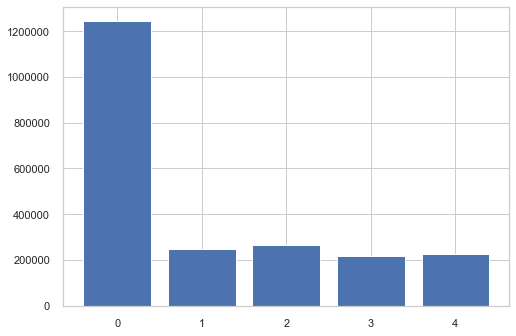

In [232]:
# Количество классов для предсказания
g = submit_df["label"].value_counts()
g = g.sort_index().T
plt.bar(g.index, g.values)

In [233]:
model_file = models_root + "xgboost_cls_hyperopt_lag_dataset_100.pkl"
dump(model, model_file)
# loaded_model = load(model_file)

['../../models/Gamma_Log_Facies_Type_Prediction/xgboost_cls_hyperopt_lag_dataset_100.pkl']